In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

directory_in = 'C:/Users/sibel/OneDrive - IIASA/social media study/India/'
directory_out = 'C:/Users/U219200/OneDrive - IIASA/Projects/SM_AIRCO/data/'

In [2]:
import scipy.stats as st

- prepare the data for each country
- make a 4x3 grid
- make function for boxplots

In [3]:
rows = ['Total','Gender', 'Age', 'Education']
columns = ['US', 'Italy', 'India - states', 'India - MH and UP', 'Mexico']
#check the N
ns = {'US':10, 'Italy':20, 'Mexico':32, 'India - states':21, 'India - MH and UP':28}


def set_titles(axes, rows):
    for i,row in enumerate(rows):
        #addition = "\n$_{Population} _{\%}$"
        ylabel = row
        
        axes[i, 0].set_ylabel("Population %", fontsize=12)
        ymax = axes[i,0].get_ylim()[1]
        xmin = axes[i,0].get_xlim()[0]
        axes[i,0].text(xmin, ymax+0.25, row, fontsize=16, ha='right')
        
    for i,col in enumerate(columns):
        title = col #+ " (N={})".format(ns[col])
        axes[0, i].set_title(title, fontsize=15, fontstyle='italic')
    return axes

In [4]:
color_dic = {'Survey':'lightgrey',
             'Social media':'salmon'}

In [5]:
df_all = pd.read_excel(directory_out+'forbox_5surveys_v2.xlsx', sheet_name='Total')

#df_all = df_all[df_all['Social media']<0.8]
df_all['Social media Spr22'] = 100*df_all['Social media']
df_all['Social media Aut22'] = 100*df_all['Social media Nov']
df_all['Social media Avg'] = (df_all['Social media Spr22'] + df_all['Social media Aut22']) / 2
df_all['Social media'] = 100 * df_all['Social media']
df_all['Social media Nov'] = 100 * df_all['Social media Nov']
df_all['Survey'] = 100*df_all['Survey']

In [6]:
df_all.head()

,region,Social media,Social media Nov,Survey,country,Social media Spr22,Social media Aut22,Social media Avg
0,Andhra Pradesh,10.620552,8.331615,0.915255,India - states,10.620552,8.331615,9.476084
1,Assam,8.061947,8.794878,3.027521,India - states,8.061947,8.794878,8.428412
2,Bihar,6.836076,7.155678,0.667128,India - states,6.836076,7.155678,6.995877
3,Chhattisgarh,7.771353,4.916995,0.307325,India - states,7.771353,4.916995,6.344174
4,Delhi,10.150656,5.899569,10.877431,India - states,10.150656,5.899569,8.025113


In [7]:
dfs = {}
for col in columns:
    df = pd.read_excel(directory_out+'forbox_{}_v2.xlsx'.format(col), sheet_name='Total')
    df['country'] = col
    df['y-fraction'] = 100 * df['y-fraction']
    if col == 'India - MH and UP':
        df = df[df['y-fraction-intention']<.8]
        df['y-fraction'] = 100 * df['y-fraction-intention']
    if col == 'US':
        df = df[df['data source']!='Survey 2015']
    regions= list(set(df['region']))
    dfavg = pd.DataFrame(index=regions)
    dfavg['region'] = regions
    dfavg['x'] = 'total'
    dfavg['data source'] = 'Social media Avg'
    dfavg['country'] = col
    a = df[df['data source']=='Social media'].set_index('region')
    b = df[df['data source']=='Social media Nov'].set_index('region')
    c = (a['y-fraction'] + b['y-fraction']) / 2
    idx = c.index.intersection(dfavg.index)
    if len(idx) == len(dfavg.index):
        print("equal")
        dfavg['y-fraction'] = c
    else:
        print(col)
        dfavg['y-fraction'] = a['y-fraction']
    
    df = pd.concat([df, dfavg])
    dfs[col] = df

equal
equal
equal
equal
equal


In [15]:
cts = list(set(df_all.country))
df_corr = pd.DataFrame(index=cts, columns=['pearson', 'spearman', 'kendall'])
for ct in cts:
    for col in df_corr.columns:
        df_corr.loc[ct, col] = df_all[df_all['country']==ct].corr(method=col).loc['Survey','Social media Nov']

In [16]:
df_corr

,pearson,spearman,kendall
US,0.076334,0.10303,0.022222
India - states,-0.221389,-0.153247,-0.133333
Italy,0.157208,0.124812,0.073684
Mexico,0.559136,0.721265,0.570294
India - MH and UP,0.091022,-0.02523,-0.025703


## Spring - November comparison

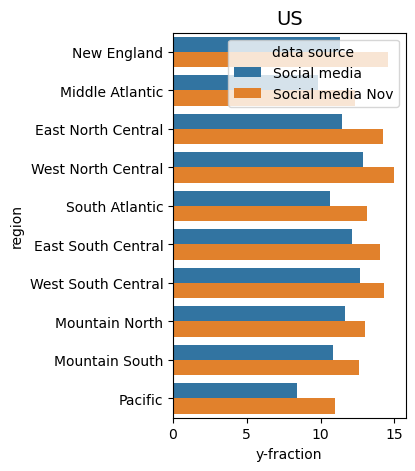

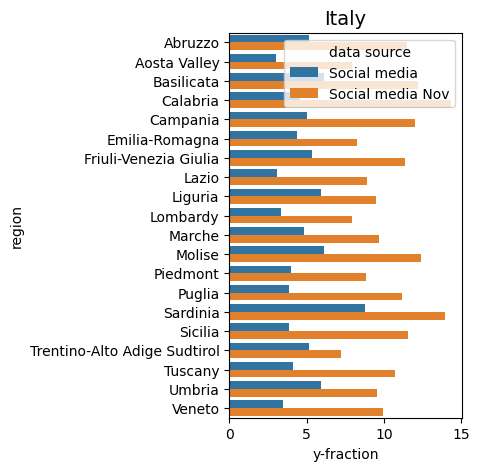

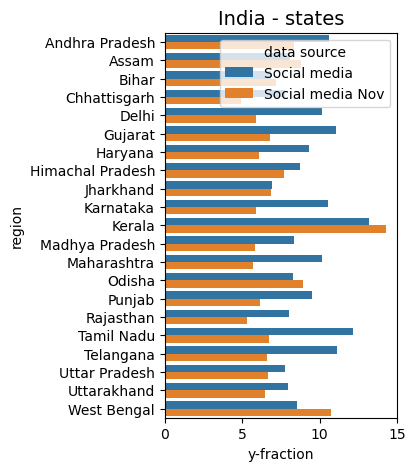

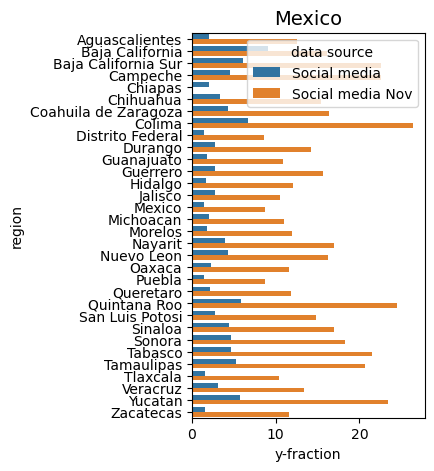

In [15]:
for cnt in columns:
    if cnt != 'India - MH and UP':
        fig,ax = plt.subplots()
        fig.set_size_inches(3, 5)
        df = dfs[cnt]
        df = df[df['data source'].isin(['Social media', 'Social media Nov'])]
        df
        ax= sns.barplot(x='y-fraction', y='region', data=df, hue='data source')
        ax.set_title(cnt, fontsize=14)
        plt.savefig(directory_out+'Spring-Nov_{}.png'.format(cnt), dpi=300, bbox_inches='tight')
        plt.show()
        

US 0.845703125
Italy 1.9073486328125e-06
India - states 2.86102294921875e-06
India - MH and UP 0.17308396100997925
Mexico 1.4957040548324585e-06


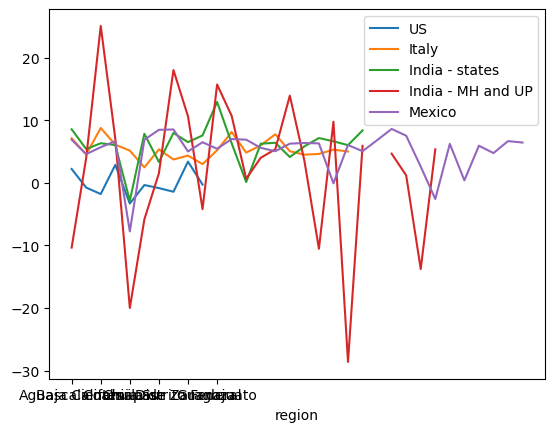

In [17]:
# Wilcoxon test
fig, ax = plt.subplots()
from scipy.stats import wilcoxon
for cnt in columns:
    df = dfs[cnt]
    a = df[df['data source']=='Social media Avg'].set_index('region')['y-fraction']
    b = df[df['data source']=='Survey'].set_index('region')['y-fraction']
    d = a - b
    res = wilcoxon(d.dropna(), alternative='two-sided')
    print(cnt, res.pvalue)
    d.plot(ax=ax, label=cnt)

    df_corr.loc[cnt, 'statistic'] = res.statistic
    df_corr.loc[cnt, 'p-value'] = res.pvalue
ax.legend()   
plt.show()

In [90]:
df_corr.to_excel(directory_out+'corr.xlsx')

In [18]:
df_corr

,pearson,spearman,kendall,statistic,p-value
US,0.076334,0.10303,0.022222,25.0,0.845703
India - states,-0.221389,-0.153247,-0.133333,2.0,0.000003
Italy,0.157208,0.124812,0.073684,0.0,0.000002
Mexico,0.559136,0.721265,0.570294,33.0,0.000001
India - MH and UP,0.091022,-0.02523,-0.025703,121.0,0.173084


In [11]:
from scipy.stats import wilcoxon

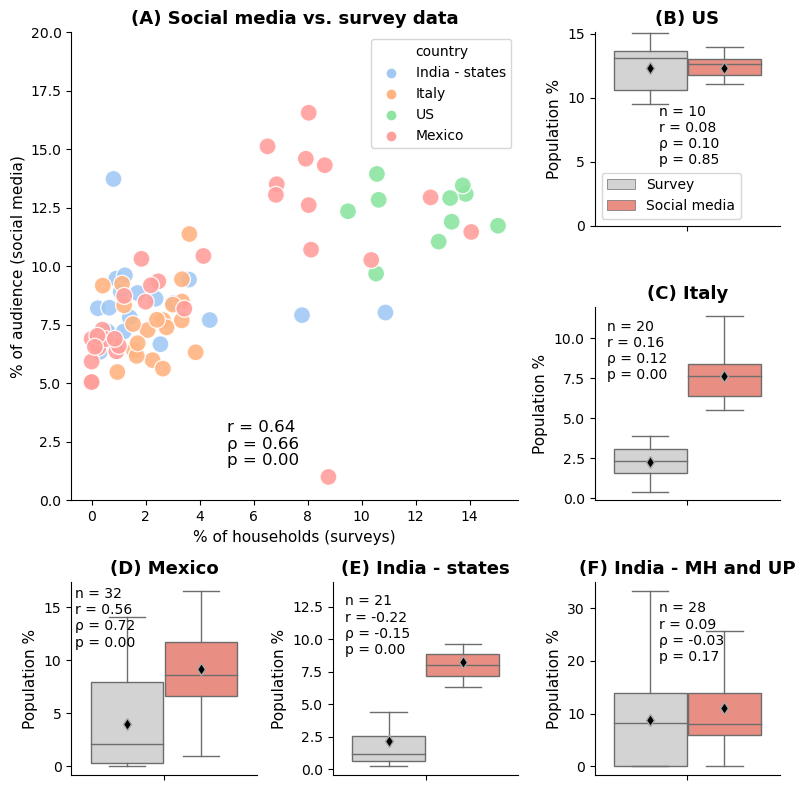

In [20]:
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import AnchoredText


fig = plt.figure(tight_layout=True)
fig.set_size_inches(8,8)
gs = gridspec.GridSpec(3, 3)

axbig = fig.add_subplot(gs[:2, :2])
axes = {}
axes['US'] = fig.add_subplot(gs[0, 2])
axes['Italy'] = fig.add_subplot(gs[1, 2])
axes['Mexico'] = fig.add_subplot(gs[2, 0])
axes['India - states'] = fig.add_subplot(gs[2, 1])
axes['India - MH and UP'] = fig.add_subplot(gs[2, 2])



sns.despine(left=False, right=True, top=True)

axbig = sns.scatterplot(x="Survey", y="Social media Avg", data=df_all[df_all['country']!='India - MH and UP'], 
                            ax=axbig, hue='country', s=150, alpha=0.9, palette='pastel')
data=df_all[df_all['country']!='India - MH and UP']
x = data[['Survey', 'Social media Avg']].dropna()['Survey'] # df_all['Survey']
y = data[['Survey', 'Social media Avg']].dropna()['Social media Avg'] # df_all['Social media Nov']
pearson = st.pearsonr(x, y)[0]
kendall = st.kendalltau(x, y).correlation
spearman = st.spearmanr(x,y).correlation
d = x-y
res = wilcoxon(d.dropna())
df_corr.loc['all', 'statistic'] = res.statistic
df_corr.loc['all', 'p-value'] = res.pvalue
axbig.set_ylim([0,20])
ymax = axbig.get_ylim()[1]

axbig.text(5, 2.9, "r = {:.2f}".format(pearson), fontsize=12, ha='left')
#axbig.text(5, 2.2, "\u03C4 = {:.2f}".format(kendall), fontsize=12, ha='left')
axbig.text(5, 2.2, "\u03C1 = {:.2f}".format(spearman), fontsize=12, ha='left')
axbig.text(5, 1.5, "p = {:.2f}".format(res.pvalue), fontsize=12, ha='left')
axbig.set_title("(A) Social media vs. survey data", fontsize=13, fontweight="bold")
axbig.set_ylabel("% of audience (social media)", fontsize=11)
axbig.set_xlabel("% of households (surveys)", fontsize=11)
# plot the boxplots
titles = {'US':"B", 'Italy':"C", 'India - states':"E", 'India - MH and UP':"F", 'Mexico':"D"}
for key, value in ns.items():
    df_plot = dfs[key]
    df_plot = df_plot[df_plot['data source'].isin(['Social media Avg', 'Survey'])]
    df_plot = df_plot.replace('Social media Avg', 'Social media')
    #axes[key].set_title(key+" (N="+str(value)+")", fontsize=13)
    axes[key].set_title("({}) ".format(titles[key]) + key, fontsize=13, fontweight="bold")
    axes[key] = sns.boxplot(ax=axes[key], x="x", y="y-fraction", hue="data source",
                 data=df_plot, palette=color_dic, linewidth=1, 
                 showmeans=True, meanprops={"marker":"d","markerfacecolor":"black", "markeredgecolor":"darkgrey", 
                                            "markersize":6}, fliersize=0)
    axes[key].set_ylabel("Population %", fontsize=11)
    axes[key].set_xlabel("", fontsize=12)
    axes[key].set_xticklabels([])
    if key != 'US':
        axes[key].get_legend().remove()
    else:
        axes[key].set_ylim([0,15.1])
        axes[key].legend(loc='best')
    #txt = "n = {}".format(value)+"\nr = {:.2f}".format(df_corr.loc[key, 'pearson']) + "\n\u03C4 = {:.2f}".format(df_corr.loc[key, 'kendall']) + "\n\u03C1 = {:.2f}".format(df_corr.loc[key, 'spearman'])
    txt = "n = {}".format(value)+"\nr = {:.2f}".format(df_corr.loc[key, 'pearson']) + "\n\u03C1 = {:.2f}".format(df_corr.loc[key, 'spearman']) + "\np = {:.2f}".format(df_corr.loc[key, 'p-value'])
    if key == 'India - states' or key == "Italy":
        anchored_text = AnchoredText(txt, loc='upper left', frameon=False, )
        axes[key].add_artist(anchored_text)
    elif key == 'India - MH and UP':
        #anchored_text = AnchoredText(txt, loc="upper right", frameon=False, pad=0) 
        #axes[key].add_artist(anchored_text)
        axes[key].text(-0.15, 20, txt)
    elif key == "US":
        axes[key].text(-0.15, 4.8, txt)
    else:
        #anchored_text = AnchoredText(txt, loc="upper left", frameon=False)
        #axes[key].add_artist(anchored_text)
        axes[key].text(-0.48, 11.3, txt)

plt.savefig(directory_out+'socialmedia_surveys_totalAvg_Wilcoxon.pdf', dpi=300, bbox_inches='tight')  
plt.savefig(directory_out+'socialmedia_surveys_totalAvg_Wilcoxon.png', dpi=300, bbox_inches='tight')  
plt.show()

In [21]:
dfss_val = {}

for j, col in enumerate(columns):
    dfss = {}
    for j, row in enumerate(['Gender', 'Age', 'Education']) :
        df = pd.read_excel(directory_out+'forbox_{}_v2.xlsx'.format(col), sheet_name=row)
        df['y-fraction'] = 100 * df['y-fraction']
        if col == 'India - MH and UP':
            df = df[df['y-fraction-intention']<.8]
            df['y-fraction'] = 100 * df['y-fraction-intention']
        if col == 'US':
            df = df[df['data source']!='Survey 2015']
        atts = list(set(df['x']))
        
        df_spr = df[df['data source']=='Social media'].set_index('region')
        df_nov = df[df['data source']=='Social media Nov'].set_index('region')
        
        for att in atts:
            dfavg = df_spr[df_spr['x']==att].copy()
            dfavg['data source'] = 'Social media Avg'
            dfavg['y-fraction'] = (df_spr[df_spr['x']==att]['y-fraction'] + df_nov[df_nov['x']==att]['y-fraction']) / 2
            dfavg['region'] = dfavg.index
            df = pd.concat([df, dfavg], ignore_index=True)
        '''
        regions= list(set(df['region']))
        atts = list(set(df['x']))
        dfavg = pd.DataFrame(columns=df.columns)
        i=0
        for att in atts:
            dfd = df[df['x']==att]
            #print(dfd)
            for region in regions:
                nov = dfd.loc[(dfd['region']==region)&(dfd['data source']=='Social media Nov'), 'y-fraction'].values[0]
                spring = dfd.loc[(dfd['region']==region)&(dfd['data source']=='Social media'), 'y-fraction'].values[0]
                avg = (spring + nov) / 2
                dfavg.loc[i, ] = [region, att, avg, 'Social media Avg']
                i+=1
        df = pd.concat([df, dfavg])
        '''
        
        if row == 'Gender':
            df['x'] = df['x'].astype('category')
            df['x'] = df['x'].cat.reorder_categories(['male', 'female',], ordered=True)
        elif row=="Age":
            df['x'] = df['x'].astype('category')
            df['x'] = df['x'].cat.reorder_categories(['18-34', '35-64', '65+'], ordered=True)
            #df['x'] = df['x'].cat.codes
        elif row=="Education" and col in ["Mexico", "India - MH and UP"]:
            df['x'] = df['x'].astype('category')
            df['x'] = df['x'].cat.reorder_categories(['Less than high school', 'High school', 'University and higher'], ordered=True)
            #df['x'] = df['x'].cat.codes
        elif row=="Education" and col=="India - states":
            df['x'] = df['x'].astype('category')
            df['x'] = df['x'].cat.reorder_categories(['Less than high school', 'High school and associate degree', 'University and higher'], ordered=True)
            #df['x'] = df['x'].cat.codes
        elif row=="Education" and col=="Italy":
            df['x'] = df['x'].astype('category')
            #print(df["x"].cat.categories)
            df['x'] = df['x'].cat.reorder_categories(['High school', 'University', 'Higher'], ordered=True)
            #df['x'] = df['x'].cat.codes
        elif row=="Education" and col=="US":
            df['x'] = df['x'].astype('category')
            df['x'] = df['x'].cat.reorder_categories(['Less than high school', 'High school',"Associate’s degree", 'University', "Higher"], ordered=True)
            #df['x'] = df['x'].cat.codes
        dfss[row] = df
    dfss_val[col] = dfss

In [22]:
dfss_val['US']['Gender'].tail()

,region,x,y-fraction,data source
75,New England,female,11.867592,Social media Avg
76,Pacific,female,8.901851,Social media Avg
77,South Atlantic,female,11.100760,Social media Avg
78,West North Central,female,13.169679,Social media Avg
79,West South Central,female,11.953363,Social media Avg


In [23]:
from matplotlib.patches import Patch

In [24]:
dfss_val['Italy']['Age']

,region,x,y-fraction,data source
0,Abruzzo,18-34,4.299058,Social media
1,Aosta Valley,18-34,3.285714,Social media
2,Basilicata,18-34,4.818593,Social media
3,Calabria,18-34,5.552804,Social media
4,Campania,18-34,5.215695,Social media
...,...,...,...,...
235,Sicilia,65+,12.619636,Social media Avg
236,Trentino-Alto Adige Sudtirol,65+,7.832772,Social media Avg
237,Tuscany,65+,11.483488,Social media Avg
238,Umbria,65+,11.595209,Social media Avg


In [29]:
# wilcoxon for comparing social media data and survey for de,ographic characteristics
from scipy.stats import wilcoxon
rows = ['Gender', 'Age', 'Education']
dfw = pd.DataFrame(columns=['country', 'row', 'attribute', 'statistic', 'pvalue'])
i=0
for cnt in columns:
    for row in rows:
        df_plot = dfss_val[cnt][row]
        df_plot = df_plot[df_plot['data source'].isin(['Social media Avg', 'Survey'])]
        df_plot = df_plot.replace('Social media Avg', 'Social media')
        atts = list(set(df_plot['x']))
        for att in atts:
            a = df_plot[(df_plot['data source']=='Social media')&(df_plot['x']==att)].set_index('region')['y-fraction']
            b = df_plot[(df_plot['data source']=='Survey')&(df_plot['x']==att)].set_index('region')['y-fraction']
            #print(cnt)
            #print(df_plot[(df_plot['data source']=='Social media')&(df_plot['x']==att)])
            d = a - b
            try:
                res = wilcoxon(d.dropna())
                dfw.loc[i, ] = [cnt, row, att, res.statistic, res.pvalue]
                i+=1
            except ValueError as e:
                dfw.loc[i, ] = [cnt, row, att, "na", "na"]
                i+=1
        

C:\Users\U219200\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\U219200\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\U219200\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\U219200\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3351: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\U219200\Anacond

In [31]:
# wilcoxon for comparing demographic characteristics for social media and survey
from scipy.stats import wilcoxon
rows = ['Gender', 'Age', 'Education']
dfw = pd.DataFrame(columns=['country', 'data source', 'row', 'statistic', 'pvalue'])
i=0
for cnt in columns:
    for row in rows:
        df_plot = dfss_val[cnt][row]
        df_plot = df_plot[df_plot['data source'].isin(['Social media Avg', 'Survey'])]
        df_plot = df_plot.replace('Social media Avg', 'Social media')
        if row == 'Gender': # male > female
            for src in ['Social media', 'Survey']:
                a = df_plot[(df_plot['data source']==src)&(df_plot['x']=='male')].set_index('region')['y-fraction']
                b = df_plot[(df_plot['data source']==src)&(df_plot['x']=='female')].set_index('region')['y-fraction']
                #print(cnt)
                #print(df_plot[(df_plot['data source']=='Social media')&(df_plot['x']==att)])
                d = a - b
                try:
                    res = wilcoxon(d.dropna(), alternative='greater')
                    dfw.loc[i, ] = [cnt, src, row, res.statistic, res.pvalue]
                    i+=1
                except ValueError as e:
                    dfw.loc[i, ] = [cnt, src, row, "na", "na"]
                    i+=1
        elif row == 'Age': # young > old
            for src in ['Social media', 'Survey']:
                a = df_plot[(df_plot['data source']==src)&(df_plot['x']=='18-34')].set_index('region')['y-fraction']
                b = df_plot[(df_plot['data source']==src)&(df_plot['x']=='35-64')].set_index('region')['y-fraction']
                #print(cnt)
                #print(df_plot[(df_plot['data source']=='Social media')&(df_plot['x']==att)])
                d = a - b
                try:
                    res = wilcoxon(d.dropna(), alternative='greater')
                    dfw.loc[i, ] = [cnt, src, row+'18>35', res.statistic, res.pvalue]
                    i+=1
                except ValueError as e:
                    dfw.loc[i, ] = [cnt, src, row+'18>35', "na", "na"]
                    i+=1
                    
                a = df_plot[(df_plot['data source']==src)&(df_plot['x']=='35-64')].set_index('region')['y-fraction']
                b = df_plot[(df_plot['data source']==src)&(df_plot['x']=='65+')].set_index('region')['y-fraction']
                #print(cnt)
                #print(df_plot[(df_plot['data source']=='Social media')&(df_plot['x']==att)])
                d = a - b
                try:
                    res = wilcoxon(d.dropna(), alternative='greater')
                    dfw.loc[i, ] = [cnt, src, row+'35>65', res.statistic, res.pvalue]
                    i+=1
                except ValueError as e:
                    dfw.loc[i, ] = [cnt, src, row+'35>65', "na", "na"]
                    i+=1
                    
        elif row == 'Education': # high > low
            for src in ['Social media', 'Survey']:
                if cnt in ['US', 'Italy']:
                    a = df_plot[(df_plot['data source']==src)&(df_plot['x']=='University')].set_index('region')['y-fraction']
                    b = df_plot[(df_plot['data source']==src)&(df_plot['x']=='High school')].set_index('region')['y-fraction']
                else:
                    a = df_plot[(df_plot['data source']==src)&(df_plot['x']=='High school')].set_index('region')['y-fraction']
                    b = df_plot[(df_plot['data source']==src)&(df_plot['x']=='Less than high school')].set_index('region')['y-fraction']

                d = a - b
                try:
                    res = wilcoxon(d.dropna(), alternative='greater')
                    dfw.loc[i, ] = [cnt, src, row+' edu2>edu1', res.statistic, res.pvalue]
                    i+=1
                except ValueError as e:
                    dfw.loc[i, ] = [cnt, src, row+' edu2>edu1', "na", "na"]
                    i+=1
                    
                if cnt in ['US', 'Italy']:
                    a = df_plot[(df_plot['data source']==src)&(df_plot['x']=='Higher')].set_index('region')['y-fraction']
                    b = df_plot[(df_plot['data source']==src)&(df_plot['x']=='University')].set_index('region')['y-fraction']
                else:
                    a = df_plot[(df_plot['data source']==src)&(df_plot['x']=='University and higher')].set_index('region')['y-fraction']
                    b = df_plot[(df_plot['data source']==src)&(df_plot['x'].str.startswith("Less than"))].set_index('region')['y-fraction']
                d = a - b
                try:
                    res = wilcoxon(d.dropna(), alternative='greater')
                    dfw.loc[i, ] = [cnt, src, row+' edu3>edu2', res.statistic, res.pvalue]
                    i+=1
                except ValueError as e:
                    dfw.loc[i, ] = [cnt, src, row+' edu3>edu2', "na", "na"]
                    i+=1

C:\Users\U219200\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\U219200\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\U219200\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\U219200\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation d

In [32]:
dfw

,country,data source,row,statistic,pvalue
0,US,Social media,Gender,55.0,0.000977
1,US,Survey,Gender,25.0,0.615234
2,US,Social media,Age18>35,0.0,1.0
3,US,Social media,Age35>65,0.0,1.0
4,US,Survey,Age18>35,34.0,0.27832
5,US,Survey,Age35>65,49.0,0.013672
6,US,Social media,Education edu2>edu1,41.0,0.09668
7,US,Social media,Education edu3>edu2,0.0,1.0
8,US,Survey,Education edu2>edu1,34.0,0.27832
9,US,Survey,Education edu3>edu2,30.0,0.422852


In [20]:
dfw.to_excel(directory_out+'\WilcoxonResults_attribute.xlsx')

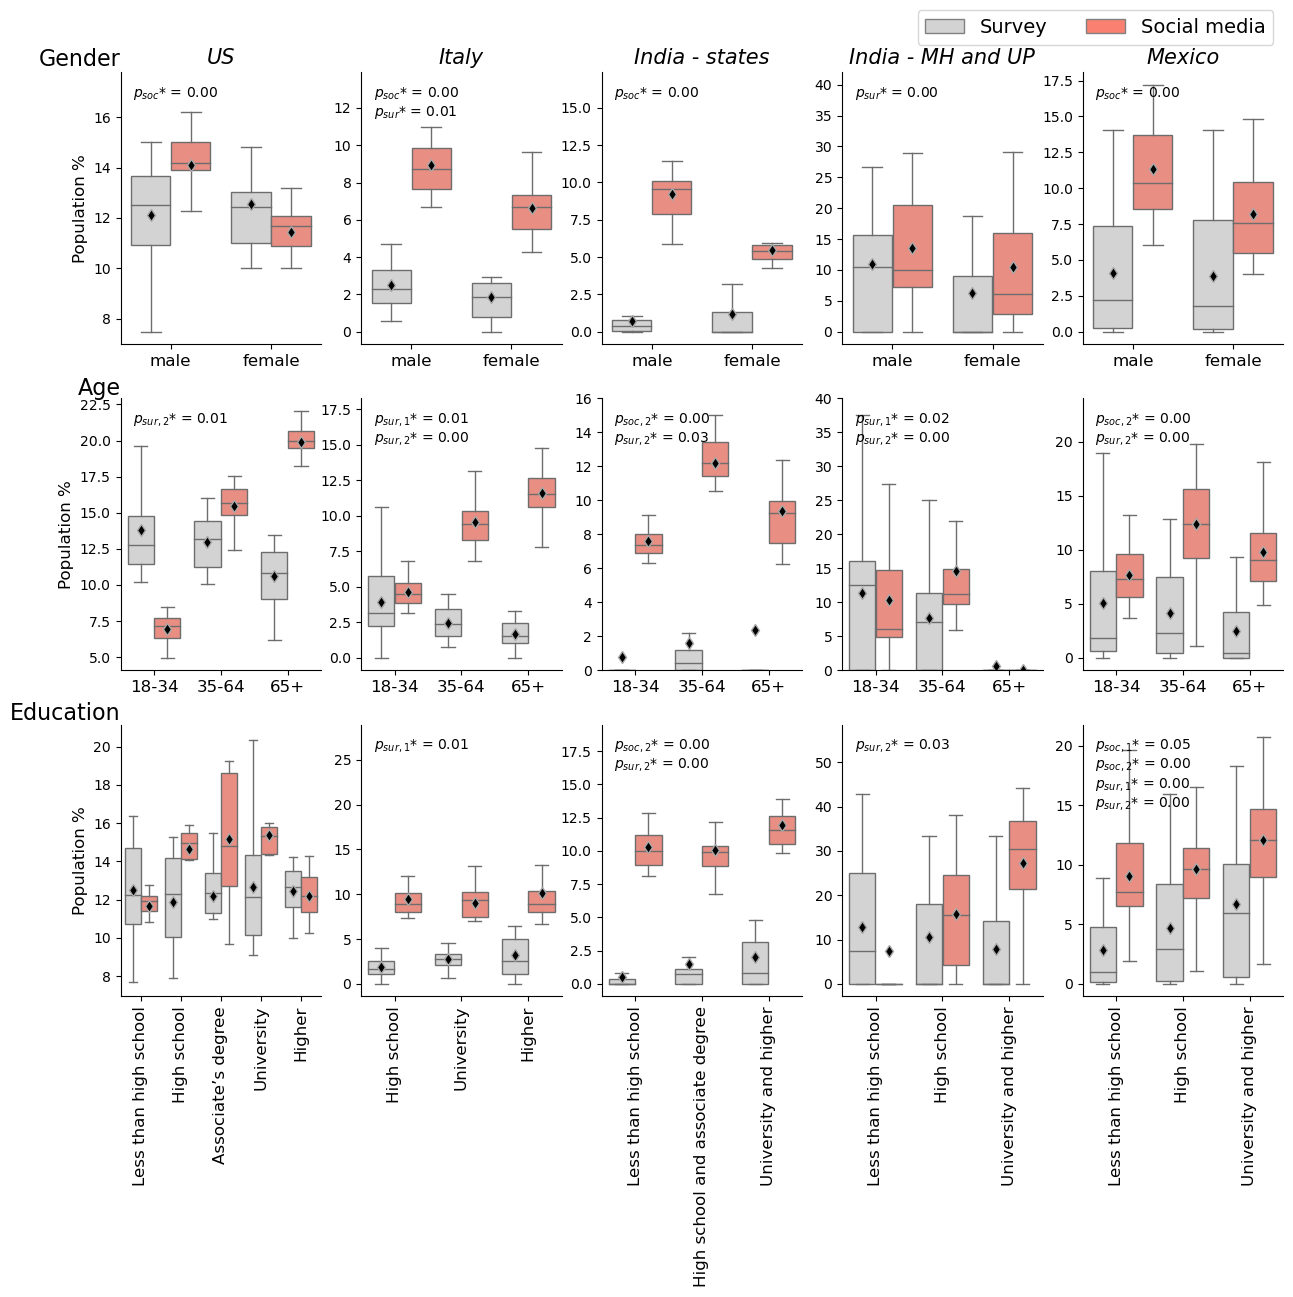

In [34]:
from matplotlib.offsetbox import AnchoredText
fig, axes = plt.subplots(3,5)
fig.set_size_inches(15,12)
fig.subplots_adjust(hspace=0.2, wspace=0.2)
rows = ['Gender', 'Age', 'Education']
color_dic = {'Survey':'lightgrey',
             'Social media':'salmon'}

for j, col in enumerate(columns):
    for i, row in enumerate(rows):
        df_plot = dfss_val[col][row]
        df_plot = df_plot[df_plot['data source'].isin(['Social media Avg', 'Survey'])]
        df_plot = df_plot.replace('Social media Avg', 'Social media')
        axes[i,j] = sns.boxplot(ax=axes[i,j], x="x", y="y-fraction", hue="data source",
                 data=df_plot, palette=color_dic, linewidth=1, 
                 showmeans=True, meanprops={"marker":"d","markerfacecolor":"black", "markeredgecolor":"darkgrey", 
                                            "markersize":6},
                            fliersize=0)
        # line through the means
        dfmean = df_plot.groupby(['x', 'data source'])['y-fraction'].mean().reset_index()

        
        #sns.pointplot(ax=axes[i,j], x="x", y="y-fraction", hue="data source", data=dfmean, palette=color_dic,dodge=0.4, 
        #              )
        axes[i,j].get_legend().remove()
        
        # annotate the p-values
        ddf = dfw[(dfw['country']==col) & (dfw['row'].str.startswith(row))]
        t_list = []
        for src in ['Social media', 'Survey']:
            if row == 'Gender':
                p = ddf.loc[ddf['data source']==src, 'pvalue'].values[0]
                sbs = src[:3].lower()
                if p and p<=0.05:
                    t =  "$p_{{{}}}$* = {:.2f}".format(sbs,p)
                    t_list.append(t)
                    
            if row == 'Age':
                p = ddf.loc[(ddf['data source']==src)&(ddf['row']=='Age18>35'), 'pvalue'].values[0]
                sbs = src[:3].lower()+",1"
                if p and p<=0.05:
                    t =  "$p_{{{}}}$* = {:.2f}".format(sbs,p)
                    t_list.append(t)
                p = ddf.loc[(ddf['data source']==src)&(ddf['row']=='Age35>65'), 'pvalue'].values[0]
                sbs = src[:3].lower()+",2"
                if p and p<=0.05:
                    t =  "$p_{{{}}}$* = {:.2f}".format(sbs,p)
                    t_list.append(t)
            if row == 'Education':
                p = ddf.loc[(ddf['data source']==src)&(ddf['row']=='Education edu2>edu1'), 'pvalue'].values[0]
                sbs = src[:3].lower()+",1"
                if p and p<=0.05:
                    t =  "$p_{{{}}}$* = {:.2f}".format(sbs,p)
                    t_list.append(t)
                p = ddf.loc[(ddf['data source']==src)&(ddf['row']=='Education edu3>edu2'), 'pvalue'].values[0]
                sbs = src[:3].lower()+",2"
                if p and p<=0.05:
                    t =  "$p_{{{}}}$* = {:.2f}".format(sbs,p)
                    t_list.append(t)
            
            
        txt = "\n".join(t_list)
        anchored_text = AnchoredText(txt, loc='upper left', frameon=False, )
        axes[i,j].add_artist(anchored_text)
        
        axes[i,j].set_xlabel("")
        axes[i,j].set_ylabel("")
        if row == 'Education':
            r = 90
        else:
            r=0
        labels = axes[i,j].get_xticklabels()
        axes[i,j].set_xticklabels(labels, rotation=r, fontsize=12)
        if row=="Age" and col=="India - states":
            axes[i,j].set_ylim([0,16])
        elif row=="Age" and col=="India - MH and UP":
            axes[i,j].set_ylim([0,40])
        sns.despine(left=False, right=True, top=True)   
axes = set_titles(axes, rows) 
legend_elements = []
for label, color in color_dic.items():
    legend_elements.append(Patch(facecolor=color, edgecolor='gray',
                         label=label)) 
fig.legend(handles=legend_elements, loc='upper right', ncol=2, bbox_to_anchor=(.9, 0.94), fontsize=14)        
       
plt.savefig(directory_out+'5surveys_boxplots_avg_pval_attributes.pdf', dpi=300, bbox_inches='tight')    
plt.show()